In [1]:
import sys
import pickle
sys.path.insert(0,'./')
import pyccl as ccl
# from importlib import reload

In [2]:
ww=np.arange(100)
for i in ww[:2]:
    print (i)

0
1


In [3]:
x={1:1,0:0}
1+ (x.get(1) or 0)

2

In [4]:
from distributed import LocalCluster
from dask.distributed import Client  # we already had this above
#http://distributed.readthedocs.io/en/latest/_modules/distributed/worker.html
LC=LocalCluster(n_workers=1,processes=False,memory_limit='50gb',threads_per_worker=10,memory_spill_fraction=.99,
               memory_monitor_interval='2000ms')
client=Client(LC)

In [5]:
client

Client Scheduler: inproc://136.152.250.183/892/1 Dashboard: http://localhost:32781/status,Cluster Workers: 1 Cores: 10 Memory: 50.00 GB


In [6]:
from cov_3X2 import *
from fisher import *

In [7]:
#only for python3
import importlib
reload=importlib.reload

# Lensing X Lensing Correlation function covariance

## Multiple redshift bins (Tomography)

In [8]:
import cov_utils
reload(cov_utils)
from cov_utils import *

In [9]:
import cov_3X2
reload(cov_3X2)
from cov_3X2 import *
from wigner_transform import *

In [10]:
import hankel_transform
from astropy.io import fits
reload(hankel_transform)
from hankel_transform import *


In [11]:
cosmo_params={'h': 0.8433,
 'Omb': 0.062,
 'Omd': 0.2837-0.062,
 's8': 0.795431,
 'Om': 0.2837,
 'As': 1.685e-09,
 'mnu': 0.0,
 'Omk': 0.0,
 'tau': 0.06,
 'ns': 0.96859,
 'w': -1,
 'wa': 0,
 'Oml': 1.-0.2837}
PS=Power_Spectra(cosmo_params=cosmo_params)
k,pk,s8=PS.camb_pk(z=[0],cosmo_params=cosmo_params,return_s8=True)
s8

0.7971166462048332

In [12]:
mnu=cosmo_h.m_nu*0
cosmo=cosmo.clone(m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
cosmo_h=cosmo.clone(H0=100) #,m_nu=mnu,Ob0=cosmo_params['Omb'],Om0=cosmo_params['Om'])
ccl_cosmo = ccl.Cosmology(Omega_c=cosmo_params['Omd'], Omega_b=cosmo_params['Omb'], 
                      h=cosmo_params['h'], A_s=cosmo_params['As'], n_s=cosmo_params['ns'],)#m_nu=[0,0,0.06])

In [13]:
use_window=True
do_sample_variance=True
SSV_cov=False
tidal_SSV=True
sigma_gamma=0.3944/sqrt(2.)  #*2**0.25

In [14]:
f_sky=0.5#3000./(4*np.pi/d2r**2)
f_sky

0.5

In [15]:
zmin=0.3
zmax=2

z=np.linspace(0,5,200)
pzs=lsst_pz_source(z=z)
x=z<zmax
x*=z>zmin
z=z[x]
pzs=pzs[x]

ns0=26 #26+np.inf #ns=inf means shape noise is zero
nbins=1  # Number of tomographic bins
z_sigma=0.03
zs_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ns0,nz_bins=nbins,use_window=use_window,f_sky=f_sky,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))

ng0=10 #26+np.inf #ns=inf means shape noise is zero
nlbins=1  # Number of tomographic bins
z_sigma=0.005
zl_bins=source_tomo_bins(zp=z,p_zp=pzs,ns=ng0,nz_bins=nlbins,use_window=use_window,f_sky=f_sky,
                         ztrue_func=ztrue_given_pz_Gaussian,zp_bias=np.zeros_like(z),
                        zp_sigma=z_sigma*np.ones_like(z))
for i in np.arange(nlbins):
    zl_bins[i]['b1']=1

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)
./cov_utils.py:81: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017
03:05:24 DEBUG:Using selector: EpollSelector
03:05:24 DEBUG:Using selector: EpollSelector
03:05:24 DEBUG:Using selector: EpollSelector
03:05:24 DEBUG:Using selector: EpollSelector
/usr/lib/python3.7/site-packages/healpy/sphtfunc.py:390: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,
03:05:29 DEBUG:Using selector: EpollSelector
03:05:29 DEBUG:Using selector: EpollSelector
03:05:29 DEBUG:Us

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


In [16]:
do_xi=True
bin_xi=True
do_cov=True
bin_cl=True
th_min=2.5/60
th_max=250./60
n_th_bins=20
th_bins=np.logspace(np.log10(th_min),np.log10(th_max),n_th_bins+1)
th=np.logspace(np.log10(th_min*0.98),np.log10(1),n_th_bins*30)
th2=np.linspace(1,th_max*1.02,n_th_bins*30)
# th2=np.logspace(np.log10(1),np.log10(th_max),60*6)
th=np.unique(np.sort(np.append(th,th2)))
thb=np.sqrt(th_bins[1:]*th_bins[:-1])

In [17]:
#Hankel Transform setup
l_max=1e2
l_maxW=1e2
l_min=2
nl=5e2
# l0=np.logspace(np.log10(l_min),np.log10(l_maxW),nl)
# l0=np.append([0,1],l0)
# l0=np.unique(np.int32(l0))
# l0_HT=l0
l0=np.arange(l_min,l_max)
l0_HT=np.arange(l_max)
  #np.arange(l_min,l_max)
# l0=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_maxW),4.e3)))   #np.arange(l_min,l_max)
# l_bins=np.unique(np.int32(np.logspace(np.log10(l_min),np.log10(l_max),50)))
l_bins=np.unique(np.int32(np.linspace(l_min,l_max,50)))
prune_theta=0
HT_kwargs={'l_min':l_min,  'l_max':l_max,
                        'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
                        'n_zeros':40000, 'prune_theta':prune_theta, 'm1_m2':[(2,2),(2,-2),(0,2),(0,0)]}
# %time HT=hankel_transform(**HT_kwargs)
# HT_kwargs2={'l_min':l_min,  'l_max':l_max,
#                         'theta_min':th_min*d2r*.9, 'theta_max':th_max*d2r,
#                         'n_zeros':40000, 'prune_theta':2, 'm1_m2':[(2,-2)]}#,(2,-2)]}

In [18]:
power_spectra_kwargs={'cosmo':cosmo,'cosmo_params':cosmo_params,'pk_func':'camb_pk_too_many_z'}

In [19]:
corr_ggl=('shear','galaxy')
corr_gg=('galaxy','galaxy')
corr_ll=('shear','shear')
m1m2=(0,2)
m1m2_gg=(0,0)

In [61]:
import window_utils
reload(window_utils)
from window_utils import *

import cov_3X2
reload(cov_3X2)
from cov_3X2 import *

In [62]:
window_lmax=29

In [63]:
#### Wigner Transform setup... Using high ell to test convergence
WT_L_kwargs={'l': l0_HT,'theta': th*d2r,'m1_m2':[(2,2),(2,-2),(0,2),(2,0),(0,0)]}
%time WT_L=wigner_transform(**WT_L_kwargs)

XI_W_L= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zl_bins,
                do_sample_variance=do_sample_variance,use_window=use_window,window_lmax=window_lmax,
                power_spectra_kwargs=power_spectra_kwargs,corrs=[corr_ll,corr_ggl,corr_gg],
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,sigma_gamma=sigma_gamma,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

XI_W_L_NW= cov_3X2(zs_bins=zs_bins,l=l0,do_cov=do_cov,bin_cl=bin_cl,l_bins=l_bins,zg_bins=zl_bins, #no window
                do_sample_variance=do_sample_variance,use_window=False,window_lmax=window_lmax,
                power_spectra_kwargs=power_spectra_kwargs,corrs=[corr_ll,corr_ggl,corr_gg],
               SSV_cov=SSV_cov,tidal_SSV_cov=tidal_SSV,do_xi=True,HT=WT_L,sigma_gamma=sigma_gamma,f_sky=f_sky,
               bin_xi=bin_xi,theta_bins=th_bins)#ns=np.inf)

./wigner_functions.py:36: RuntimeWarning: invalid value encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./wigner_functions.py:36: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./wigner_functions.py:36: RuntimeWarning: divide by zero encountered in true_divide
  d_mat/=np.sqrt(binom(k+b,b))
./cov_utils.py:81: RuntimeWarning: invalid value encountered in true_divide
  Win0=2*jn(1,l_th)/l_th
./angular_power_spectra.py:23: RuntimeWarning: divide by zero encountered in true_divide
  self.cl_f=(l+0.5)**2/(l*(l+1.)) # cl correction from Kilbinger+ 2017
03:29:57 DEBUG:Using selector: EpollSelector
03:29:57 DEBUG:Using selector: EpollSelector
03:29:57 DEBUG:Using selector: EpollSelector
03:29:57 DEBUG:Using selector: EpollSelector


CPU times: user 2.18 s, sys: 3.98 s, total: 6.15 s
Wall time: 4.6 s
wigner done dict_keys([0, 2])


03:29:58 DEBUG:Using selector: EpollSelector
03:29:58 DEBUG:Using selector: EpollSelector
03:29:58 DEBUG:Using selector: EpollSelector
03:29:58 DEBUG:Using selector: EpollSelector


In [64]:
XI_W_L.m1_m2s

{('shear', 'shear'): [(2, 2), (2, -2)],
 ('galaxy', 'shear'): [(0, 2)],
 ('shear', 'galaxy'): [(2, 0)],
 ('galaxy', 'galaxy'): [(0, 0)],
 'window': [(0, 0)]}

In [65]:
gg_i=[(i,i) for i in np.arange(zl_bins['n_bins'])]
XI_W_L.stack_indxs[corr_gg]=gg_i
# XI_W_L.stack_indxs

In [66]:
XI_W_L.Win.wig_3j[0][0,1,1]

-0.57735026

In [67]:
# %time xiHG=XI_H.xi_tomo()
# %time xiHG2=XI_H2.xi_tomo()
%time xiWG_L=XI_W_L.xi_tomo()
%time xiWG_L_nw=XI_W_L_NW.xi_tomo()

/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


Note: redshifts have been re-sorted (earliest first)
CPU times: user 4 s, sys: 227 ms, total: 4.23 s
Wall time: 957 ms
Note: redshifts have been re-sorted (earliest first)


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 3.89 s, sys: 197 ms, total: 4.09 s
Wall time: 891 ms


In [68]:
%time clG=XI_W_L.cl_tomo()
%time clG_nw=XI_W_L_NW.cl_tomo()
#%time clH=XI_H.cl_tomo()

Note: redshifts have been re-sorted (earliest first)


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 3.9 s, sys: 205 ms, total: 4.11 s
Wall time: 874 ms
Note: redshifts have been re-sorted (earliest first)


/usr/lib/python3.7/site-packages/astropy/units/quantity.py:639: RuntimeWarning: divide by zero encountered in true_divide
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


CPU times: user 3.97 s, sys: 250 ms, total: 4.22 s
Wall time: 911 ms


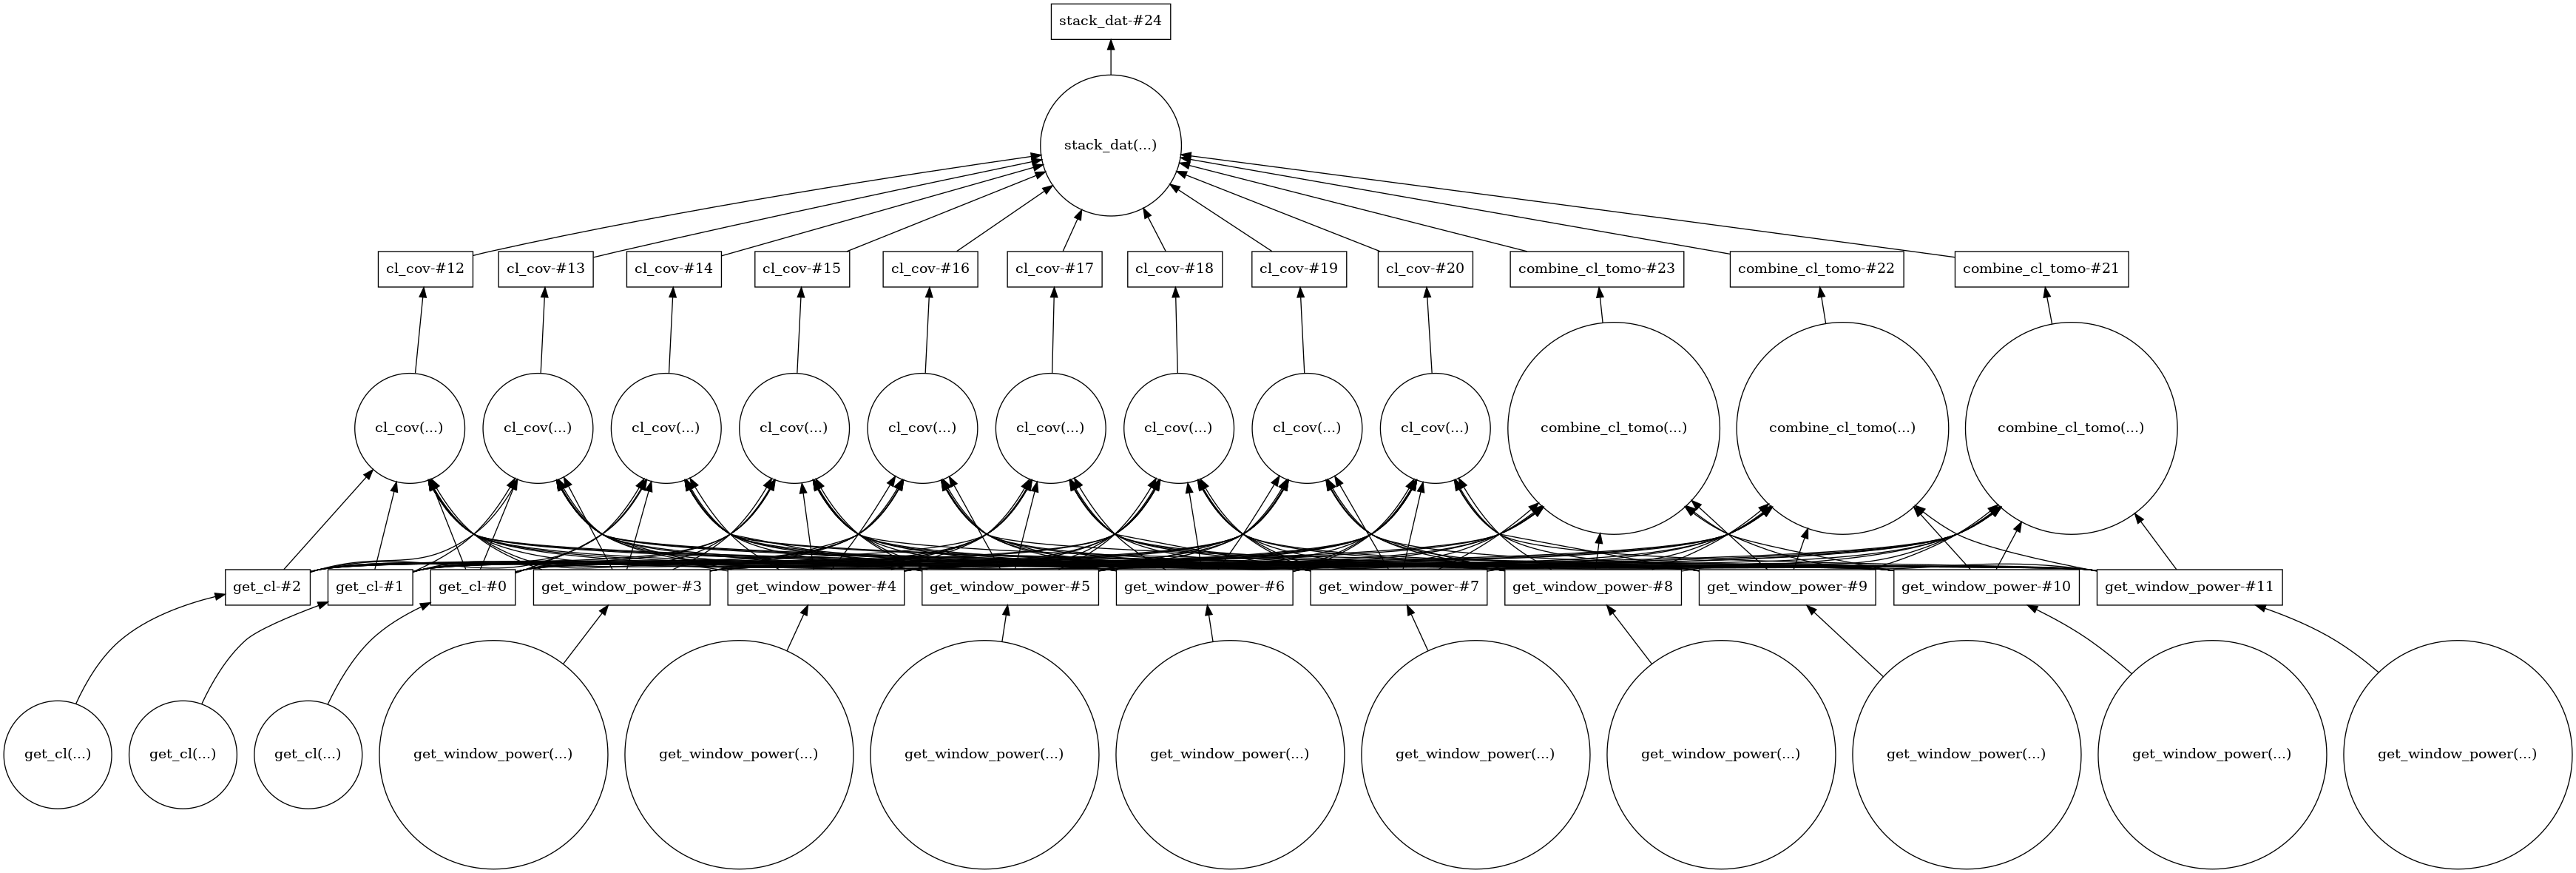

In [69]:
clG['stack'].visualize()

In [70]:
XI_W_L.Win.window_lmax

29

In [71]:
tr='galaxy'
corr_t=(tr, tr)
corrs_t=(tr,tr,tr,tr)
indxs_t=(0,0,0,0)
indx_t=(0,0)
win_t=XI_W_L.Win.Win['cov'][corrs_t][indxs_t]['M1423'].compute()
win0_t=XI_W_L.Win.Win[corr_t][indx_t]['M'].compute()
cl_t=clG['cl_b'][corr_t].compute()[corr_t][indx_t]
cl_t_nw=clG_nw['cl_b'][corr_t].compute()[corr_t][indx_t]
cov_t=clG['cov'][corrs_t][indxs_t].compute()
cov_t_nw=clG_nw['cov'][corrs_t][indxs_t].compute()
l=XI_W_L.l

In [72]:
cl_t/cl_t_nw

array([0.54103056, 0.51064881, 0.50067766, 0.49641533, 0.49435117,
       0.4933172 , 0.49282904, 0.49264446, 0.49264593, 0.49276104,
       0.49294516, 0.49316974, 0.4934132 , 0.49365766, 0.49389533,
       0.49411784, 0.49431838, 0.49448891, 0.49462683, 0.49473311,
       0.4948139 , 0.49487497, 0.49491796, 0.49494441, 0.49495486,
       0.49495286, 0.4949452 , 0.49493776, 0.49493349, 0.49493271,
       0.49493773, 0.49494923, 0.49496627, 0.49498702, 0.49499328,
       0.49497068, 0.49492147, 0.49484197, 0.49472613, 0.49456234,
       0.49433578, 0.49402328, 0.49358564, 0.49295753, 0.49201145,
       0.4904627 , 0.48753938, 0.48007496, 0.42417781])

In [73]:
cov_inv=np.linalg.inv(cov_t['final_b'])
cov_nw_inv=np.linalg.inv(cov_t_nw['final_b'])
SN=cl_t@cov_inv@cl_t
SN_nw=cl_t_nw@cov_nw_inv@cl_t_nw
SN,SN_nw,SN/SN_nw

(2392.5947092583383, 2437.1870098167587, 0.981703373447008)

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
03:30:12 DEBUG:findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to DejaVu Sans ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


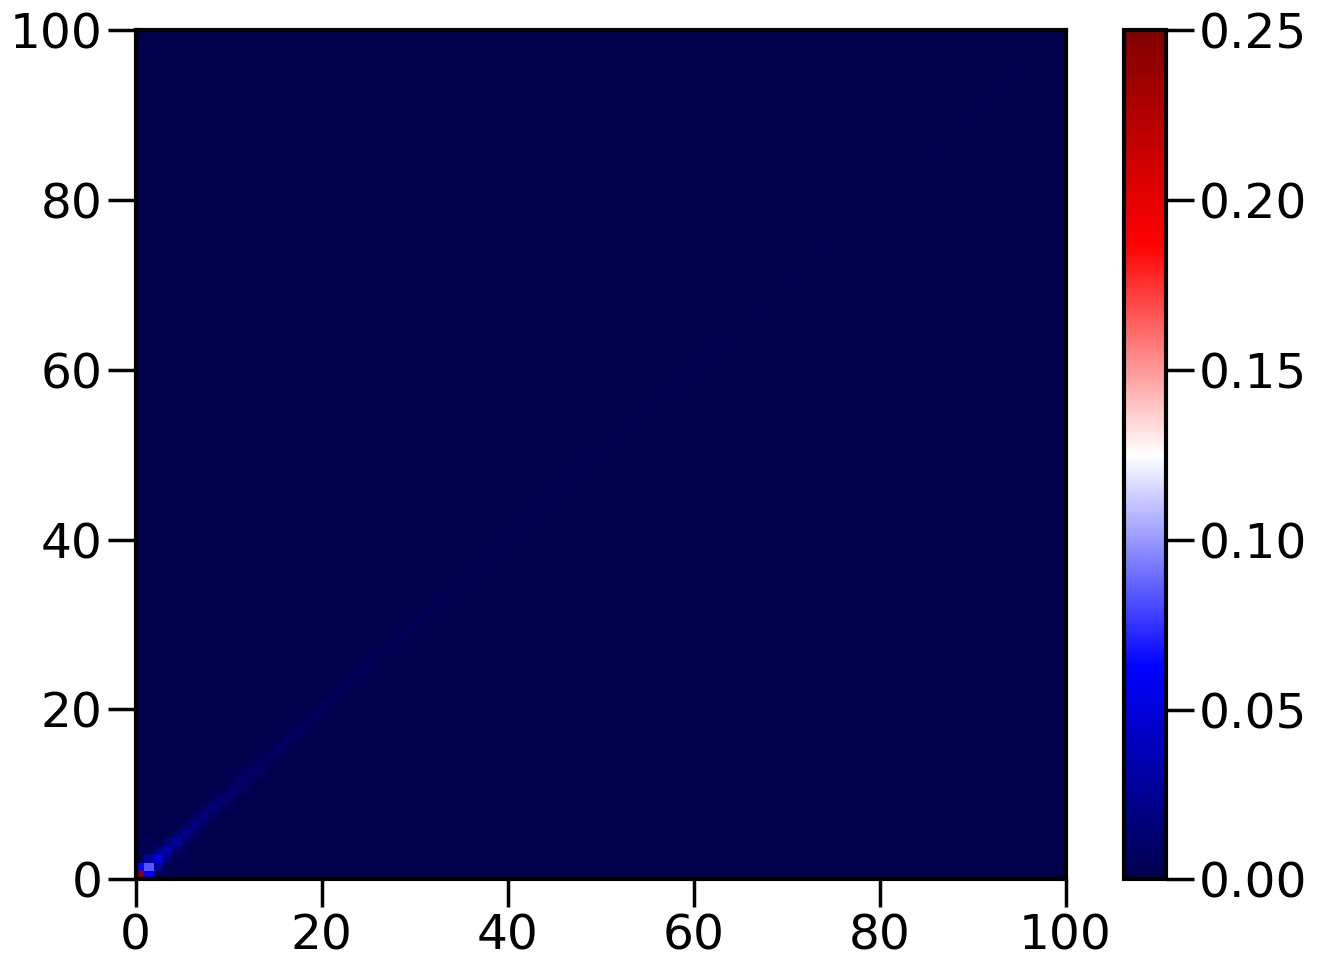

In [74]:
pcolor(win_t,cmap='seismic')
colorbar()

In [75]:
mask=zl_bins[0]['window']>-1.e10
nside=256
cl_map=hp.ma(hp.synfast(cl_t,nside=nside))
cl_map[~mask]=hp.UNSEEN
cl_t2=hp.anafast(cl_map,lmax=100)

Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


/usr/lib/python3.7/site-packages/healpy/sphtfunc.py:390: FutureChangeWarning: The order of the input cl's will change in a future release.
Use new=True keyword to start using the new order.
See documentation of healpy.synalm.
  category=FutureChangeWarning,


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
03:30:14 DEBUG:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=normal:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf') with score of 0.050000
03:30:14 DEBUG:findfont: Matching :family=STIXGeneral:style=italic:variant=normal:weight=normal:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf') with score of 0.050000
03:30:14 DEBUG:findfont: Matching :family=STIXGeneral:style=normal:variant=normal:weight=bold:stretch=normal:size=35.0 to STIXGeneral ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralBol.ttf') with score of 0.000000
03:30:15 DEBUG:findfont: Matching :family=STIXNonUnicode:style=no

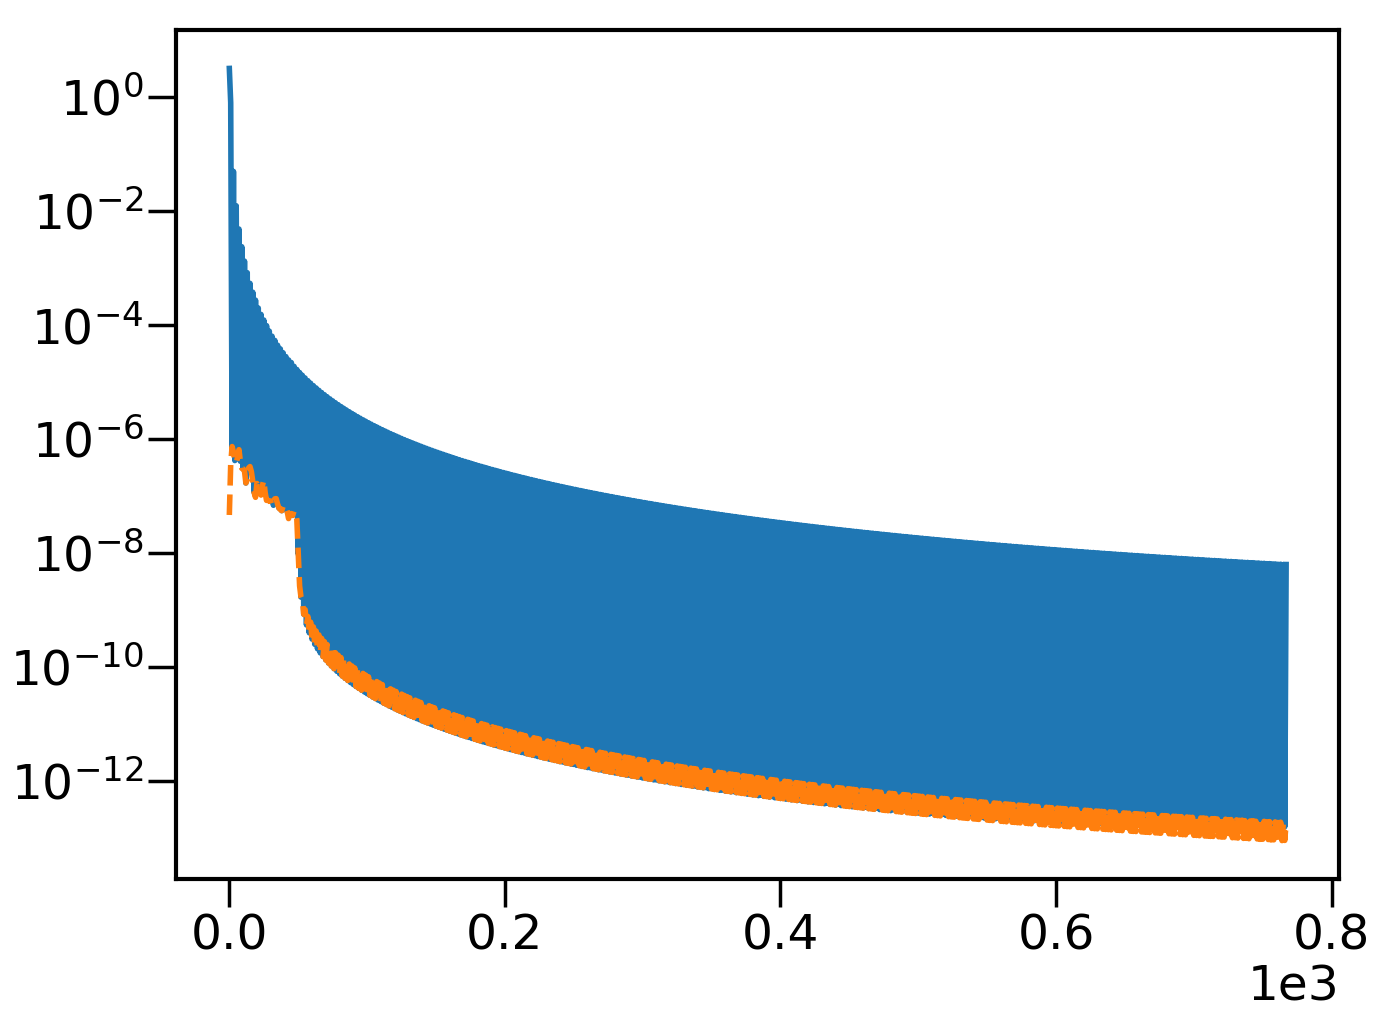

In [76]:
plot(hp.anafast(zl_bins[0]['window']))
plot(hp.anafast(zl_bins[0]['window']-1),'--')
# xscale('log')
yscale('log')

In [77]:
x=zl_bins[0]['window']>-1.e10
zl_bins[0]['window'][x].sum()/len(x)

0.5000606815691845

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
03:30:17 DEBUG:findfont: Matching :family=DejaVu Sans:style=normal:variant=normal:weight=normal:stretch=normal:size=42.0 to DejaVu Sans ('/usr/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000


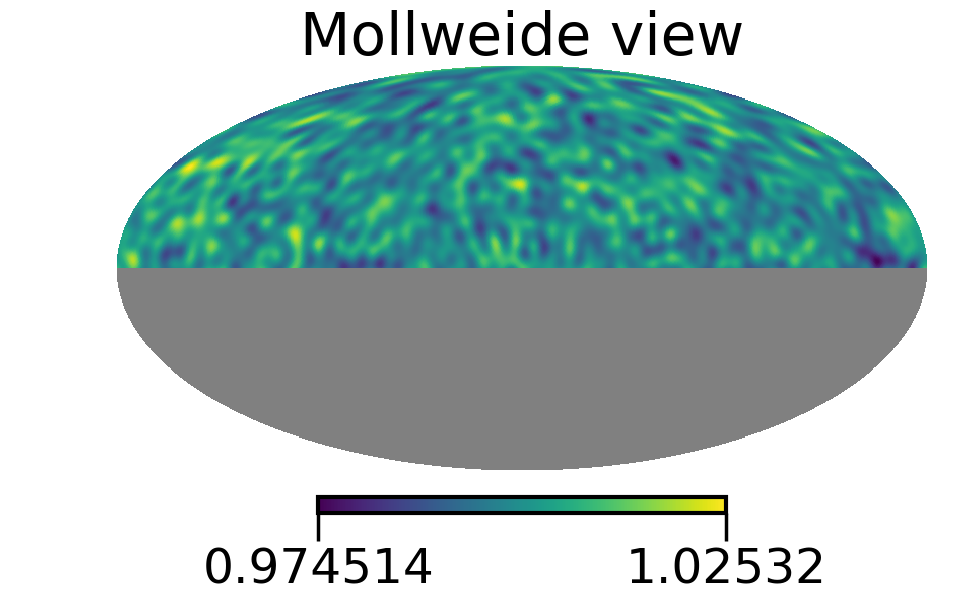

In [78]:
hp.mollview(zl_bins[0]['window'])

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


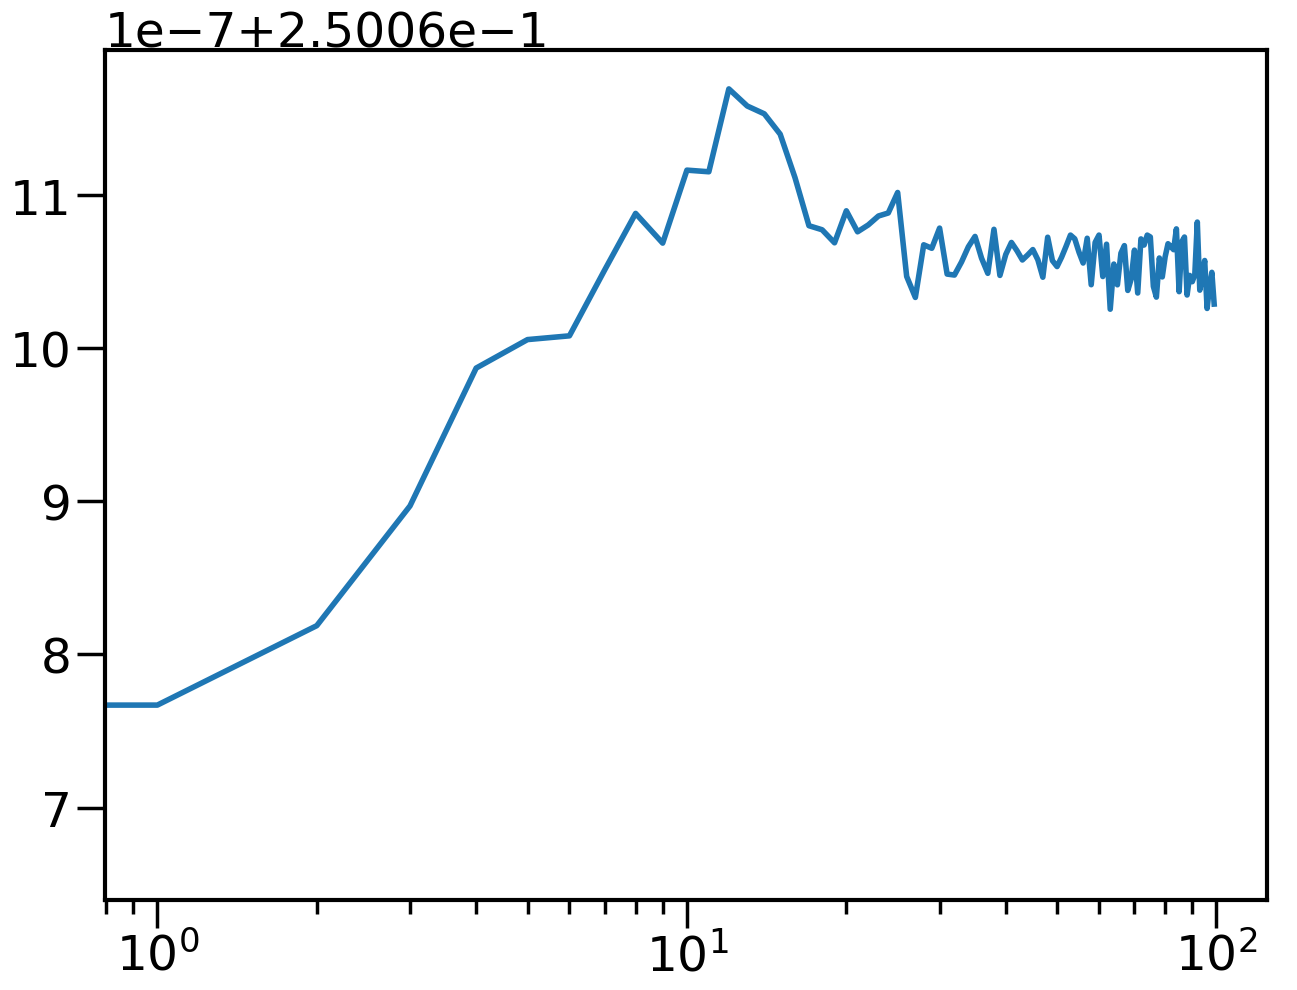

In [79]:
plot(XI_W_L.l,np.diag(win0_t))
xscale('log')
# yscale('log')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


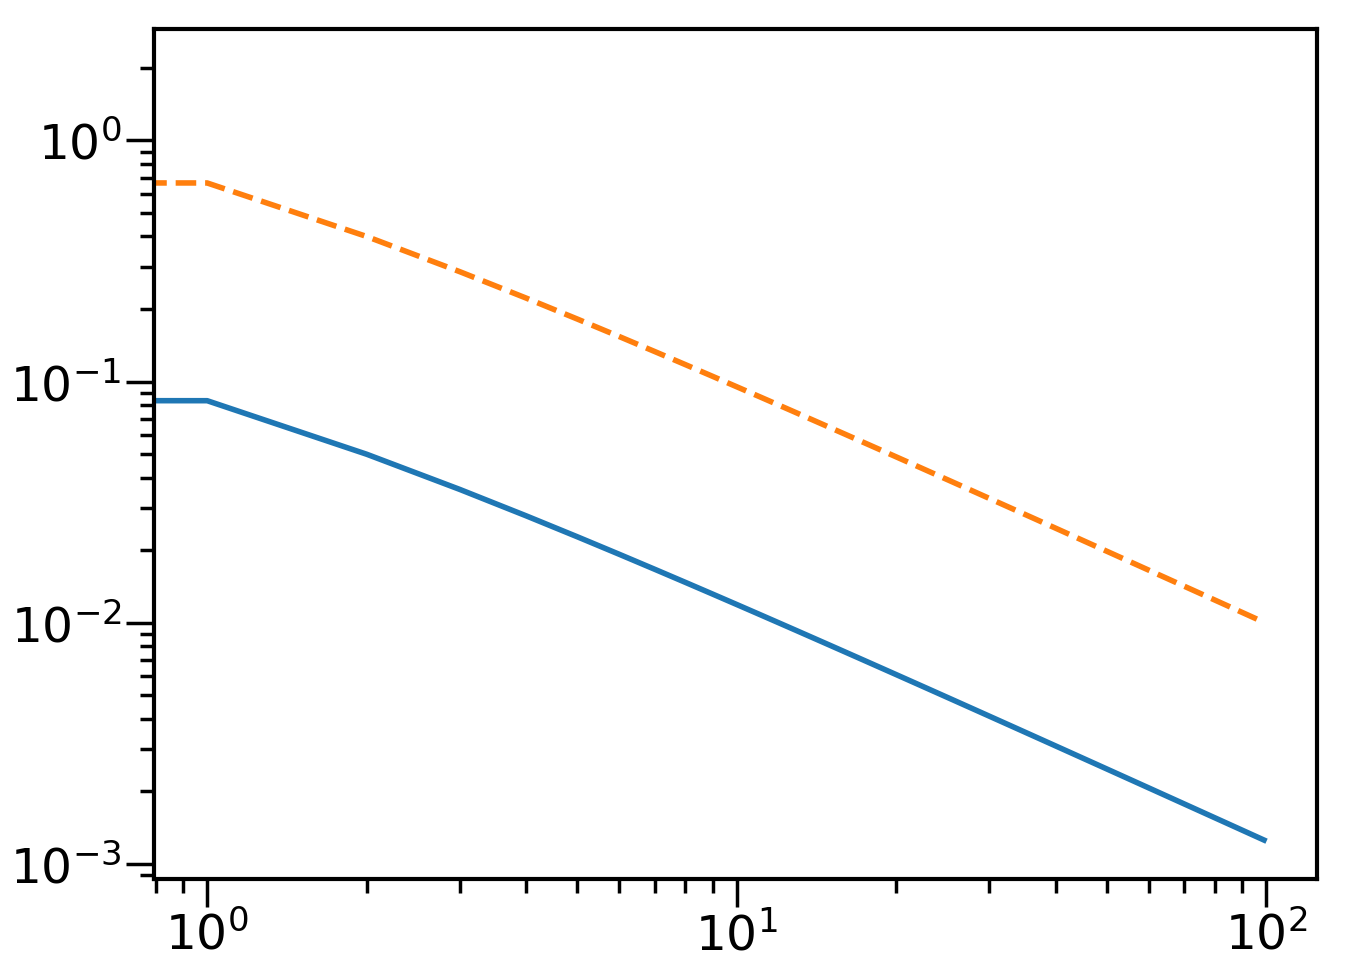

In [80]:
plot(XI_W_L.l,np.diag(win_t))
plot(XI_W_L.l,1./XI_W_L.cov_utils.gaussian_cov_norm,'--')
xscale('log')
yscale('log')

In [81]:
%time xiW_L=xiWG_L['stack'].compute()
%time xiW_L_nw=xiWG_L_nw['stack'].compute()

CPU times: user 38.2 s, sys: 2.11 s, total: 40.4 s
Wall time: 4.42 s
CPU times: user 2.09 s, sys: 166 ms, total: 2.25 s
Wall time: 501 ms


In [82]:
clG['cl_b'].keys()

dict_keys([('galaxy', 'galaxy'), ('galaxy', 'shear'), ('shear', 'galaxy'), ('shear', 'shear')])

In [83]:
XI_W_L.corrs

[('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'galaxy')]

In [84]:
XI_W_L.Win.Win.keys()

dict_keys(['cl', 'xi', ('shear', 'shear'), ('shear', 'galaxy'), ('galaxy', 'shear'), ('galaxy', 'galaxy'), 'cov'])

In [85]:
%time cl_L=clG['stack'].compute()
%time cl_L_nw=clG_nw['stack'].compute()

CPU times: user 36.1 s, sys: 1.9 s, total: 38 s
Wall time: 3.87 s
CPU times: user 145 ms, sys: 70.2 ms, total: 215 ms
Wall time: 127 ms


In [86]:
f=1
xiW_L_nw_inv=np.linalg.inv(xiW_L_nw['cov']*f)
print ((np.dot(xiW_L_nw['xi'],np.dot(xiW_L_nw_inv,xiW_L_nw['xi']))))

cov_xiWL_inv=np.linalg.inv(xiW_L['cov']*f)
print ((np.dot(xiW_L['xi'],np.dot(cov_xiWL_inv,xiW_L['xi']))))

-964588.6515235963
nan


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


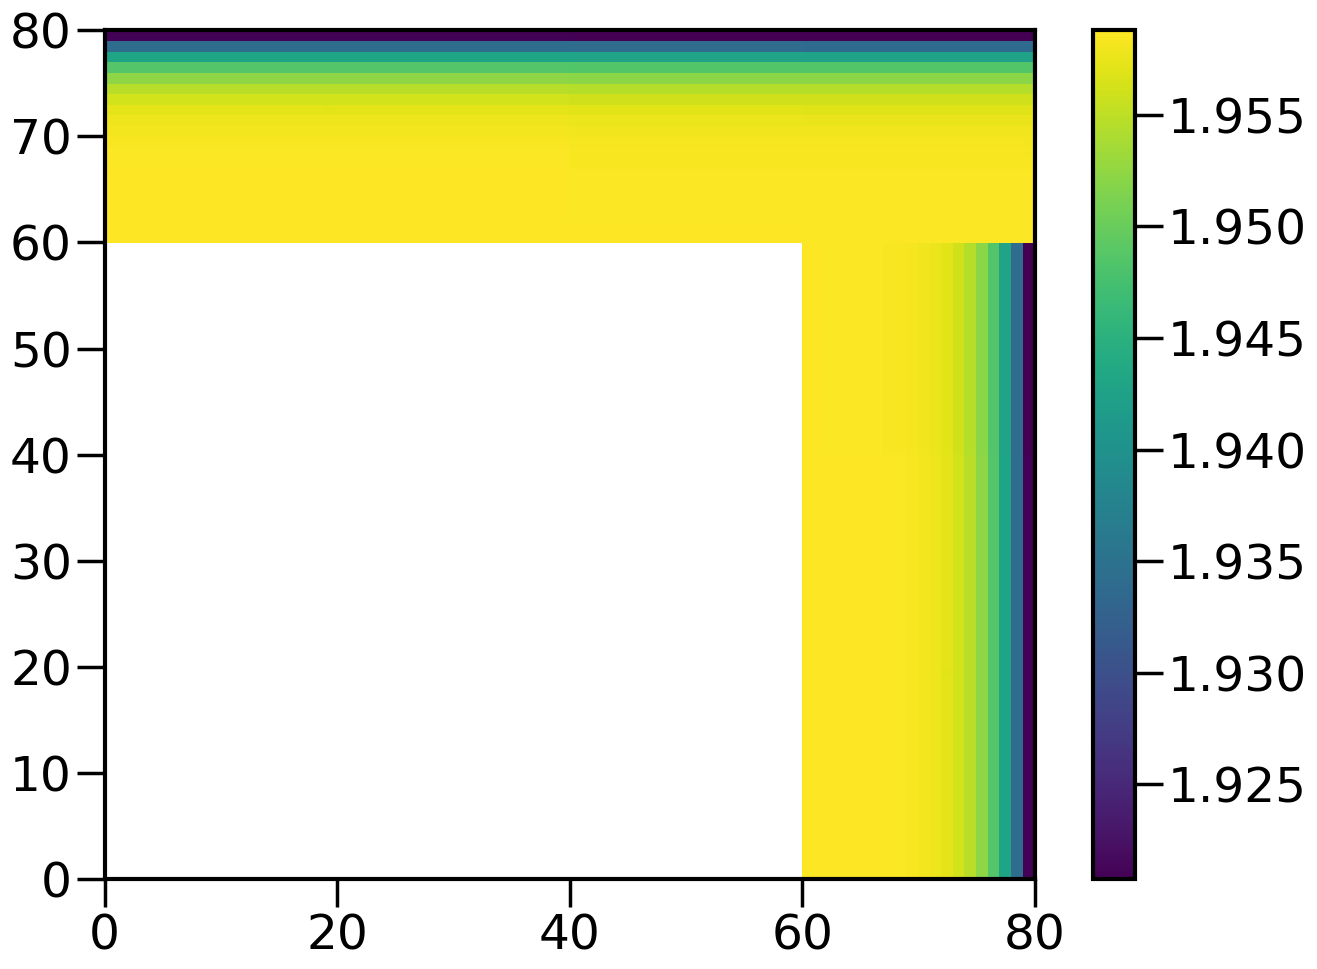

In [87]:
pcolor(xiW_L_nw['cov']/xiW_L['cov'])
colorbar()

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


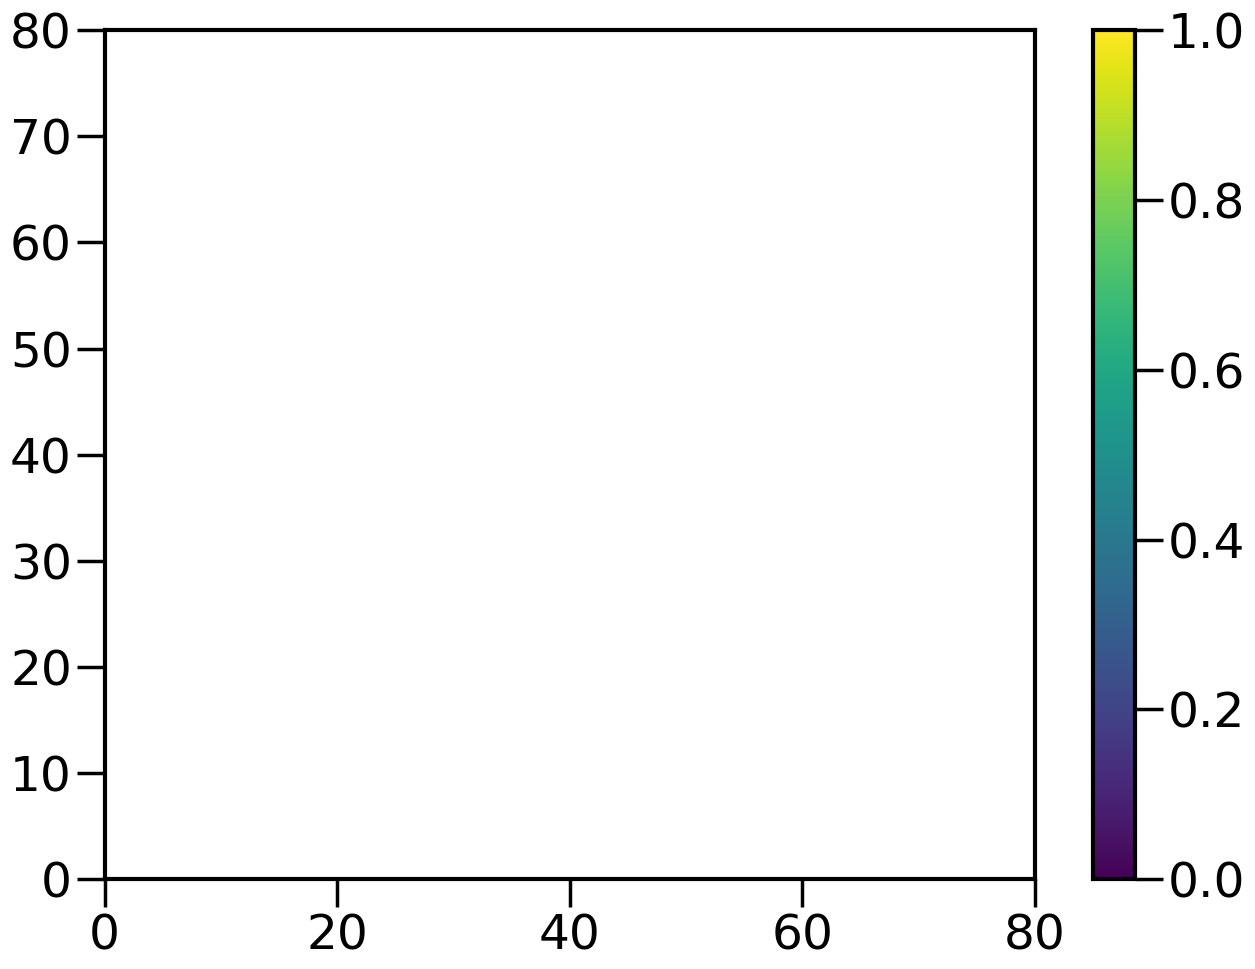

In [88]:
pcolor(xiW_L_nw_inv/cov_xiWL_inv)
colorbar()

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


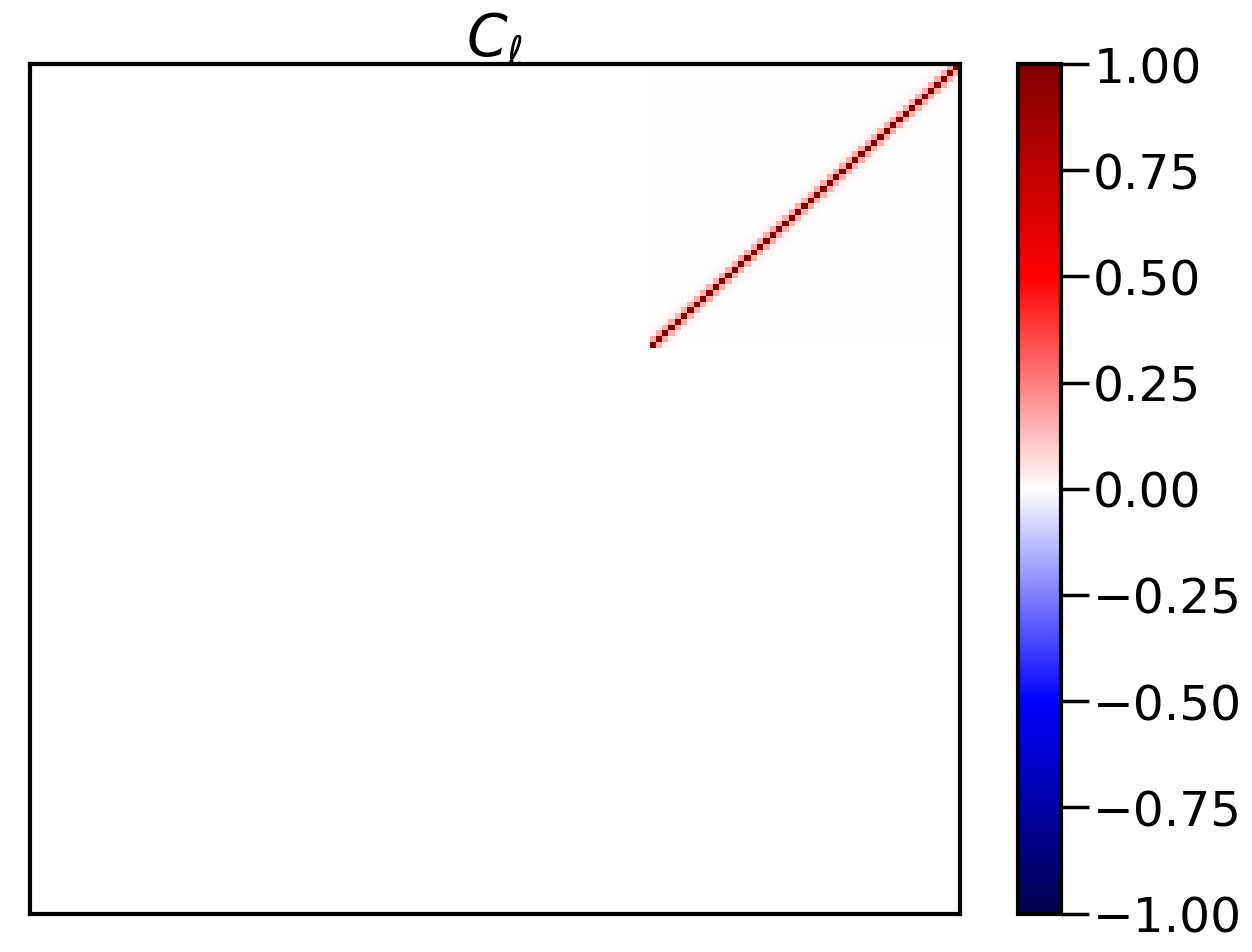

In [89]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('$C_\ell$')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


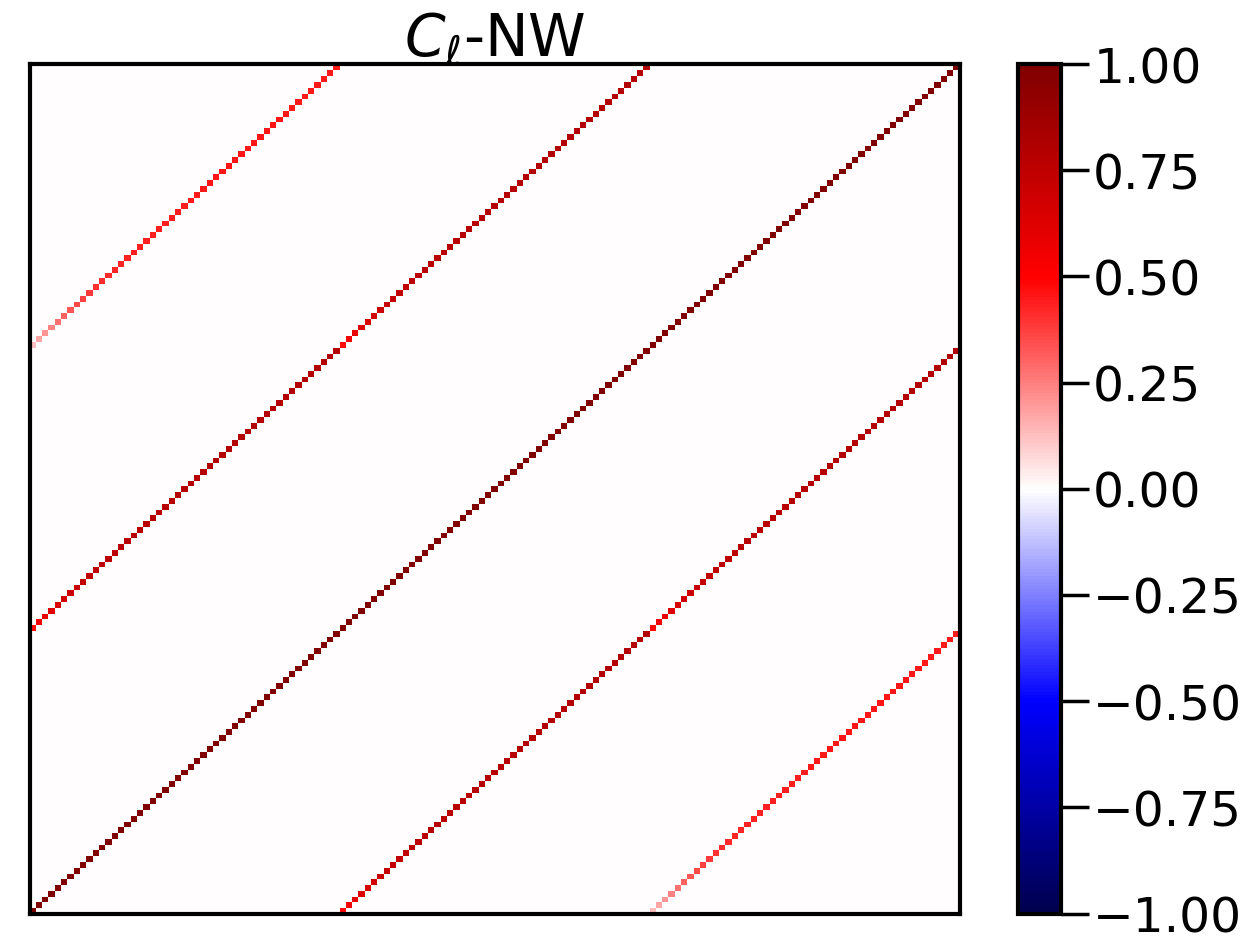

In [90]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(cl_L_nw['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('$C_\ell$-NW')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


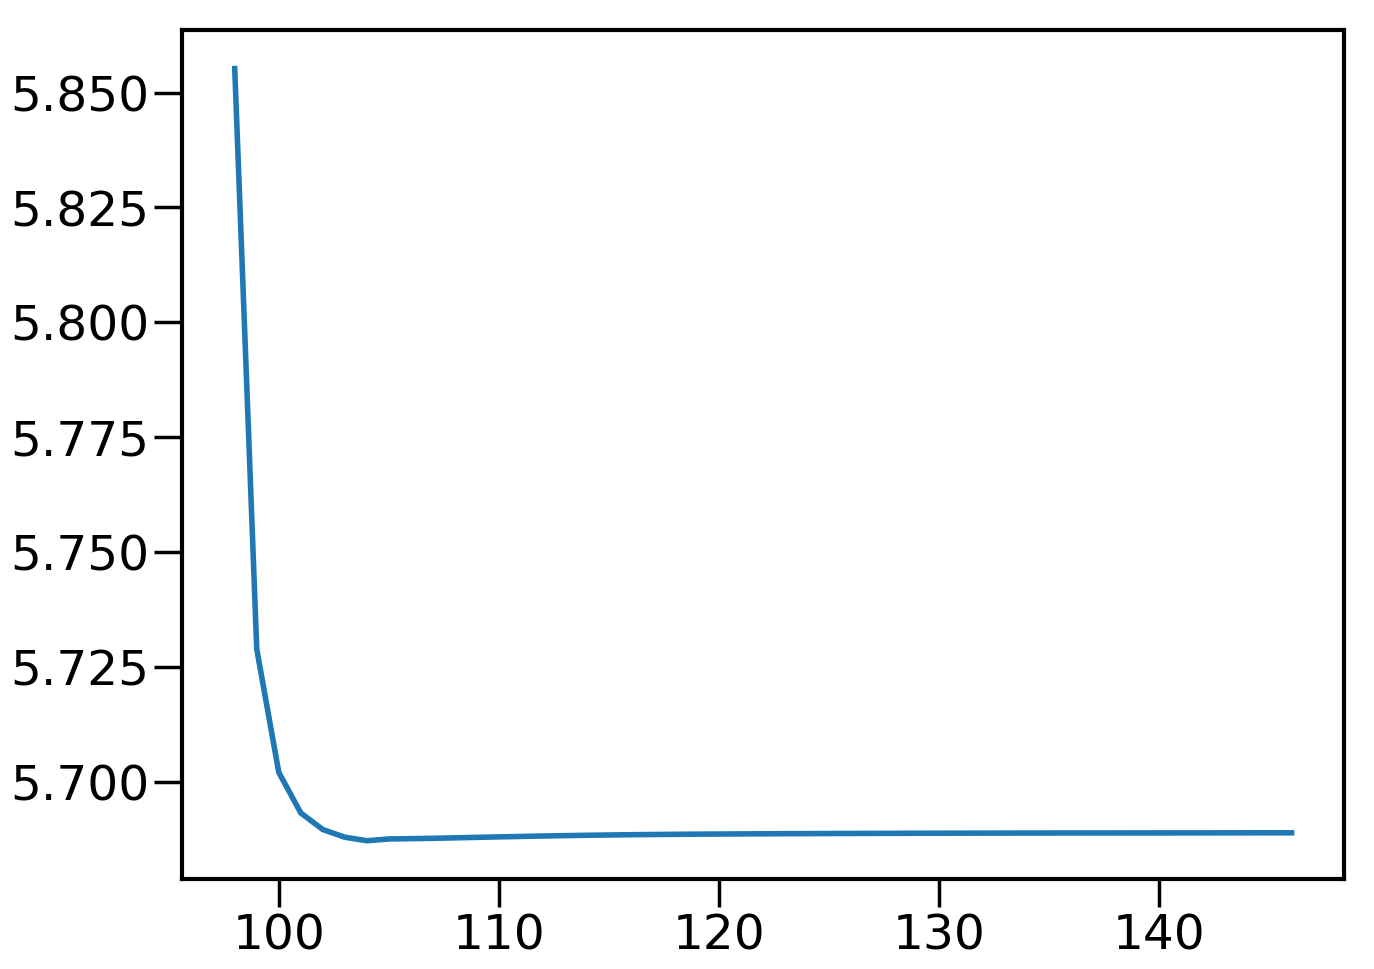

In [91]:
R=np.diag(cl_L_nw['cov']/cl_L['cov'])
plot(R)

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


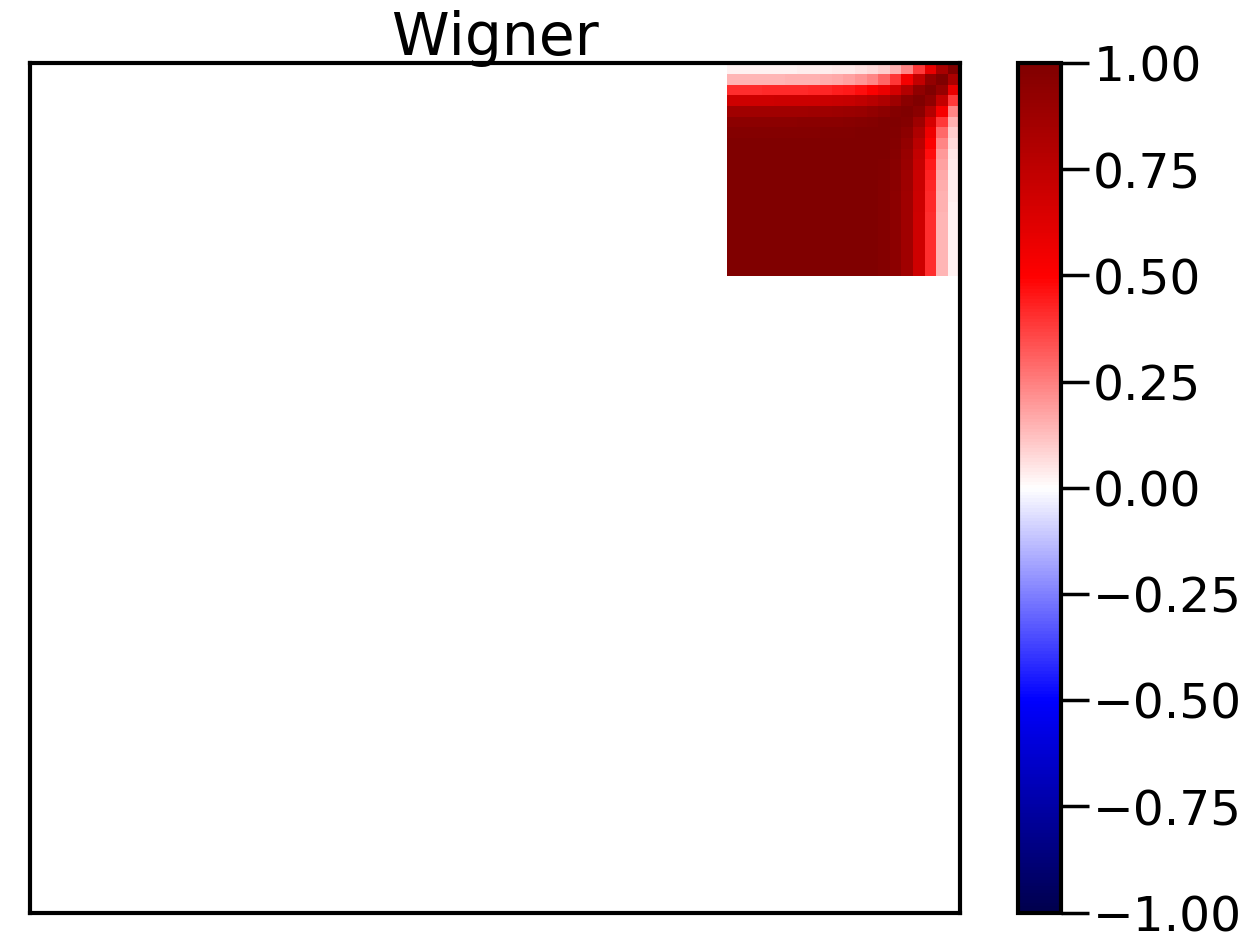

In [92]:
cc=XI_W_L.cov_utils
corrW=cc.corr_matrix(xiW_L['cov'])
pcolor(corrW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


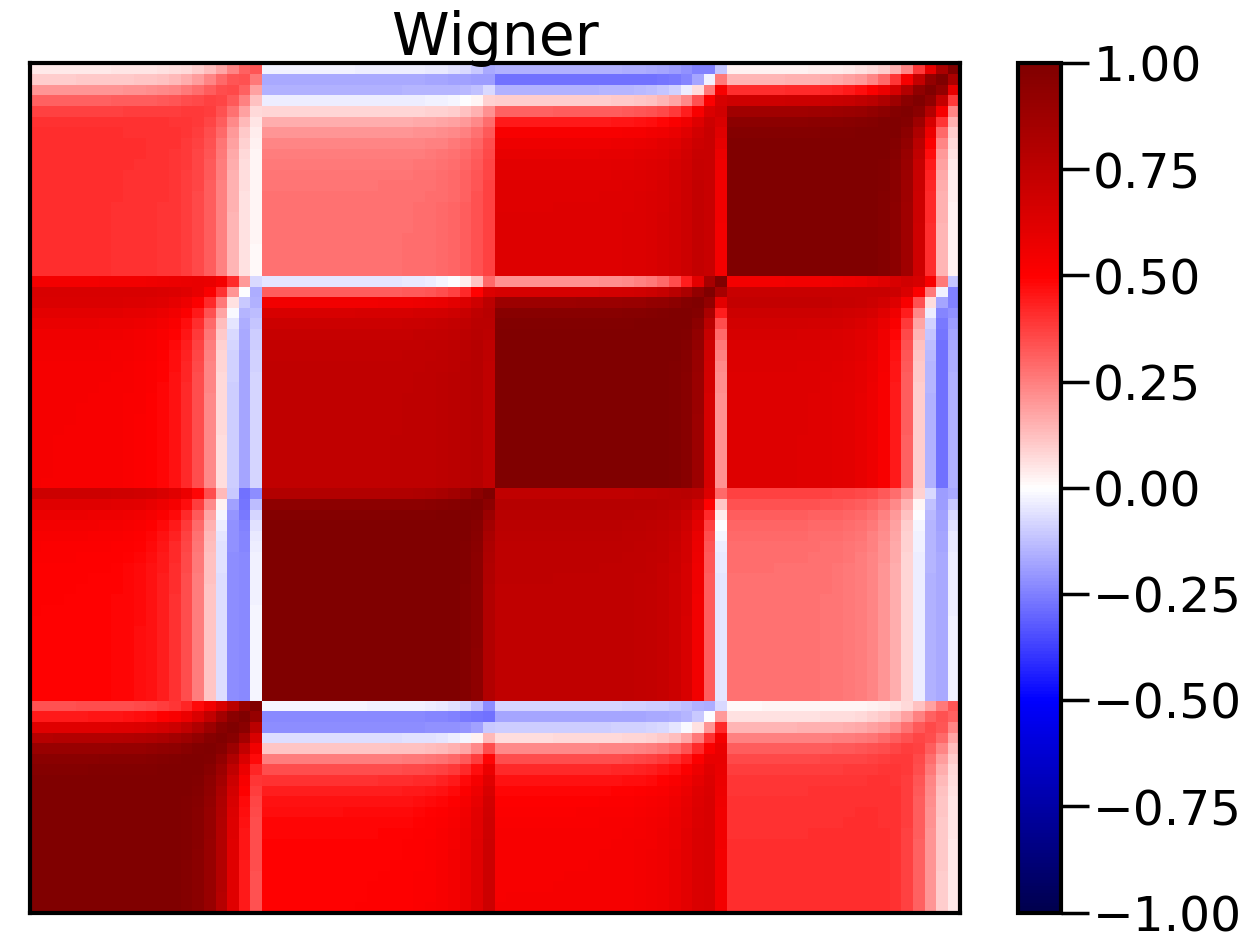

In [93]:
cc=XI_W_L.cov_utils
corrNW=cc.corr_matrix(xiW_L_nw['cov'])
pcolor(corrNW,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

/usr/lib/python3.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


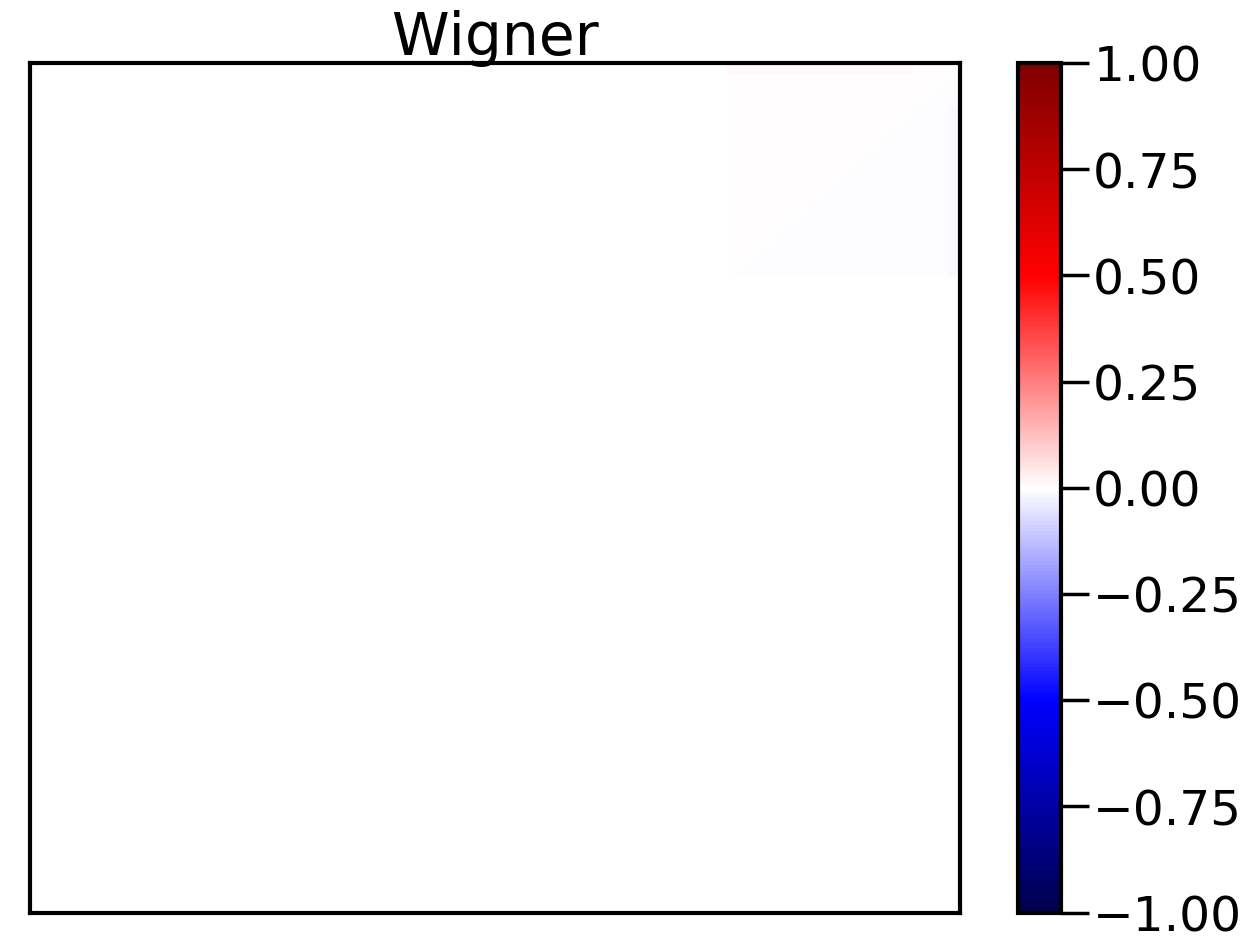

In [94]:
pcolor(corrW/corrNW-1,vmin=-1,vmax=1,cmap='seismic')
# xlabel(r'$\theta$ (degrees)')
# ylabel(r'$\theta$ (degrees)')
title('Wigner')
# hlines(60,0,120)
# vlines(60,0,120)
xticks([])
yticks([])


colorbar()
show()
# corrL=cc.corr_matrix(clL['cov'])
# pcolor(corrL,vmin=-1,vmax=1,cmap='seismic')

In [95]:
np.diag(xiW_L_nw['cov'])/np.diag(xiW_L['cov'])

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       1.95861959, 1.95861574, 1.95860964, 1.95860002, 1.95858478,
       1.95856064, 1.95852241, 1.95846188, 1.95836605, 1.95821298,
       1.95797075, 1.95758898, 1.95698563, 1.95603365, 1.95453

In [96]:
1.92/1.57

1.2229299363057324

In [97]:
xiW_L_nw['cov']/xiW_L['cov']

array([[       nan,        nan,        nan, ..., 1.94291686, 1.93413294,
        1.92092555],
       [       nan,        nan,        nan, ..., 1.94291686, 1.93413294,
        1.92092555],
       [       nan,        nan,        nan, ..., 1.94291686, 1.93413294,
        1.92092556],
       ...,
       [1.94291686, 1.94291686, 1.94291686, ..., 1.94273622, 1.94273614,
        1.94273572],
       [1.93413294, 1.93413294, 1.93413294, ..., 1.93395436, 1.93395439,
        1.93395423],
       [1.92092555, 1.92092555, 1.92092556, ..., 1.92074963, 1.9207499 ,
        1.92075002]])

In [98]:
xiW_L_nw['xi']/xiW_L['xi']

array([       nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
              nan,        nan,        nan,        nan,        nan,
       1.00589769, 1.00589385, 1.00588776, 1.00587815, 1.00586292,
       1.00583879, 1.00580052, 1.00573981, 1.00564338, 1.00548857,
       1.00524159, 1.00484719, 1.00421034, 1.00316875, 1.00141